In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sqlalchemy import create_engine
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [3]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "weatherinszeged"
table_name = "weatherinszeged"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from {}".format(table_name), con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [4]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


<IPython.core.display.Javascript object>

In [5]:
X = df[["humidity", "windspeed", "windbearing", "pressure"]]
y = df["temperature"]

<IPython.core.display.Javascript object>

In [6]:
model = LinearRegression()
model.fit(X,y)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<IPython.core.display.Javascript object>

## Assumption one: Linearity of the model in its coefficients

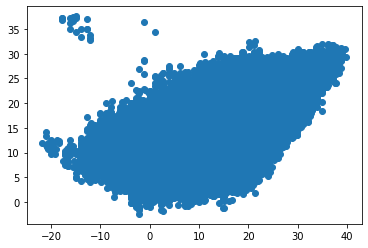

<IPython.core.display.Javascript object>

In [7]:
y_pred = model.predict(X)
plt.scatter(y, y_pred)

In [8]:
# not entirely sure the best way to check this.

<IPython.core.display.Javascript object>

## Assumption two: the error term should be zero on average

In [9]:
errors = y - y_pred
errors.mean()
# yup

-3.568957307638909e-15

<IPython.core.display.Javascript object>

## Assumption three: homoscedasticity

In [10]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(y_pred, errors)
lev_stats = levene(y_pred, errors)

print(
    "Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(
        bart_stats[0], bart_stats[1]
    )
)
print(
    "Levene test statistic value is {0:3g} and p value is {1:.3g}".format(
        lev_stats[0], lev_stats[1]
    )
)

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


<IPython.core.display.Javascript object>

We reject the null so our errors are heteroskedastic

## Assumption four: low multicollinearity

In [11]:
X_const = sm.add_constant(X)

results = sm.OLS(y, X_const).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 1.750e+04
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        15:52:13   Log-Likelihood:            -3.2821e+05
No. Observations:               96453   AIC:                         6.564e+05
Df Residuals:                   96448   BIC:                         6.565e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          37.9264      0.233    162.709      0.000      37.470      38.383
humidity      -32.4962      0.123   -264.288      0.000     -32.737     -32.255
windspeed      -0.2014      0.003    -57.557      0.000      -0.208      -0.195
windbearing     0.0040      0.000     18.463      0.000       0.004       0.004
pressure       -0.0007      0.000     -3.452      0.001      -0.001      -0.000
==============================================================================
Omnibus:                     3375.432   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3793.297
Skew:                          -0.455   Prob(JB):                         0.00
Kurtosis:                       3.339   Cond. No.                     1.06e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

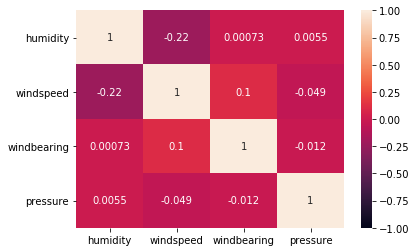

<IPython.core.display.Javascript object>

In [19]:
sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True)
#none of the features are highly correlated.

## Assumption five: error terms should be uncorrelated with one another

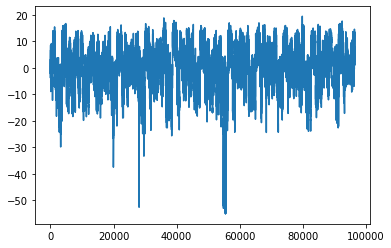

<IPython.core.display.Javascript object>

In [12]:
plt.plot(errors)
#they appear to be uncorrelated

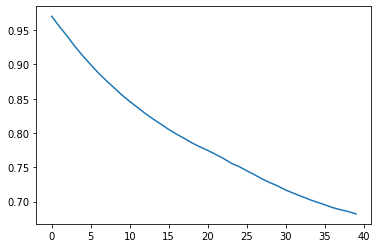

<IPython.core.display.Javascript object>

In [13]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()
#nevermind, acf says our correlation is very high for the errors

## Assumption six: features shouldn't be correlated with the errors

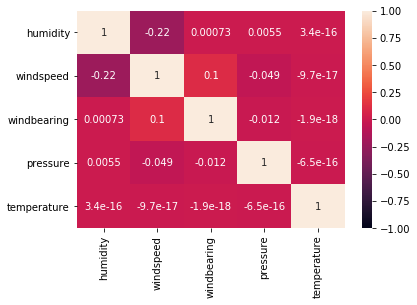

<IPython.core.display.Javascript object>

In [25]:
errors_df = pd.concat([X, pd.DataFrame(errors)], axis=1)
sns.heatmap(errors_df.corr(), vmin=-1, vmax=1, annot=True)
#there doesn't seem to be high correlation of errors with features

## Discussion

The data is not homoskedastic which means it will be overconfident in its predictions. We may need to use more data or deal with outliers (transforms)

Error terms are correlated which, again shows that we may be ommitting an important feature.

Sounds like the best course of action is to decide which features to add into the model.

# Part 2: houseprices

In [27]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "houseprices"
table_name = "houseprices"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

df = pd.read_sql_query("select * from {}".format(table_name), con=engine)

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

<IPython.core.display.Javascript object>

In [28]:
df = df.drop(columns=["poolqc", "miscfeature", "alley", "fence"])
df["fireplacequ"] = df["fireplacequ"].fillna("None")
df["lotfrontage"] = df["lotfrontage"].fillna(df["lotfrontage"].median())
df = df.drop(columns=["garagecars", "garagequal", "garagecond"])
df["garageyrblt"] = df["garageyrblt"].fillna(df["garageyrblt"].median())
df["garagefinish"] = df["garagefinish"].fillna("None")
df["garagetype"] = df["garagetype"].fillna("None")
bsmt_cols = ["bsmtfintype2", "bsmtexposure", "bsmtfintype1", "bsmtcond", "bsmtqual"]
for col in bsmt_cols:
    df[col] = df[col].fillna("None")
df["masvnrarea"] = df["masvnrarea"].fillna(0.0)
df["masvnrtype"] = df["masvnrtype"].fillna("None")
df = df.dropna()
df = df.drop(columns=["lotconfig", "utilities"])

dummy_df = df.copy()
for col in df.columns:
    if df[col].dtype == "object":
        dummy_df = pd.concat(
            [dummy_df, pd.get_dummies(df[col], drop_first=True)], axis=1
        )
        dummy_df = dummy_df.drop(columns=col)

<IPython.core.display.Javascript object>

In [29]:
X = dummy_df.drop(columns=["id", "saleprice"])
y = dummy_df["saleprice"]

<IPython.core.display.Javascript object>

## Assumption one: Linearity of the model in its coefficients

In [31]:
X_const = sm.add_constant(X)

results = sm.OLS(y, X_const).fit()


<IPython.core.display.Javascript object>

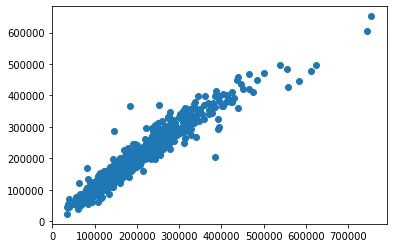

<IPython.core.display.Javascript object>

In [34]:
y_pred = results.predict(X_const)
plt.scatter(y, y_pred)

Looks linear to me

## Assumption two: the error term should be zero on average

In [35]:
errors = y - y_pred
errors.mean()
#good

-3.539573350465506e-08

<IPython.core.display.Javascript object>

## Assumption three: homoscedasticity

In [36]:
bart_stats = bartlett(y_pred, errors)
lev_stats = levene(y_pred, errors)

print(
    "Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(
        bart_stats[0], bart_stats[1]
    )
)
print(
    "Levene test statistic value is {0:3g} and p value is {1:.3g}".format(
        lev_stats[0], lev_stats[1]
    )
)

Bartlett test statistic value is 1946.36 and p value is 0
Levene test statistic value is 817.685 and p value is 9.6e-159


<IPython.core.display.Javascript object>

We have heteroskedastic errors

## Assumption four: low multicollinearity

In [37]:
results.summary()
#there is a lot of colinearity in this model. Need to do better feature selection

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     72.33
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        16:15:21   Log-Likelihood:                -16600.
No. Observations:                1459   AIC:                         3.365e+04
Df Residuals:                    1234   BIC:                         3.484e+04
Df Model:                         224                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.194e+05   1.05e+06     -0.779      0.436   -2.88e+06    1.25e+06
mssubclass       -0.9465     81.574     -0.012      0.991    -160.986     159.093
lotfrontage      40.7739     41.959      0.972      0.331     -41.545     123.093
lotarea           0.7543      0.109      6.890      0.000       0.540       0.969
overallqual    6943.9227   1016.423      6.832      0.000    4949.814    8938.031
overallcond    5959.6384    872.249      6.832      0.000    4248.383    7670.894
yearbuilt       335.6633     77.263      4.344      0.000     184.081     487.245
yearremodadd    100.0175     55.380      1.806      0.071      -8.633     208.668
masvnrarea       18.9795      5.776      3.286      0.001       7.649      30.310
bsmtfinsf1       17.1622      2.896      5.926      0.000      11.480      22.844
bsmtfinsf2        6.5395      5.998      1.090      0.276      -5.228      18.307
bsmtunfsf        -1.6734      2.776     -0.603      0.547      -7.119       3.772
totalbsmtsf      22.0282      4.070      5.412      0.000      14.043      30.014
firstflrsf       12.8223      6.222      2.061      0.040       0.615      25.029
secondflrsf      33.0497      5.452      6.062      0.000      22.353      43.747
lowqualfinsf    -10.9910     13.466     -0.816      0.415     -37.409      15.427
grlivarea        34.8806      5.481      6.364      0.000      24.127      45.634
bsmtfullbath    666.8708   1985.796      0.336      0.737   -3229.039    4562.780
bsmthalfbath   -985.7100   3033.854     -0.325      0.745   -6937.792    4966.372
fullbath       3132.6199   2208.427      1.418      0.156   -1200.067    7465.307
halfbath       1252.5421   2098.675      0.597      0.551   -2864.823    5369.907
bedroomabvgr  -3804.2996   1368.574     -2.780      0.006   -6489.289   -1119.310
kitchenabvgr  -1.398e+04   5621.863     -2.487      0.013    -2.5e+04   -2953.485
totrmsabvgrd   1191.7514    951.890      1.252      0.211    -675.750    3059.253
fireplaces     7162.5957   2560.430      2.797      0.005    2139.318    1.22e+04
garageyrblt      23.3912     58.896      0.397      0.691     -92.155     138.938
garagearea       28.0341      5.842      4.799      0.000      16.573      39.496
wooddecksf       12.8161      5.869      2.184      0.029       1.302      24.330
openporchsf       2.9579     11.540      0.256      0.798     -19.682      25.598
enclosedporch     5.1479     12.442      0.414      0.679     -19.262      29.558
threessnporch    32.3784     22.603      1.433      0.152     -11.966      76.722
screenporch      34.9838     12.130      2.884      0.004      11.186      58.782
poolarea         79.8529     18.408      4.338      0.000      43.739     115.967
miscval           0.1297      1.425      0.091      0.927      -2.666       2.925
mosold         -446.7559    245.992     -1.816   

<IPython.core.display.Javascript object>

## Assumption five: error terms should be uncorrelated with one another

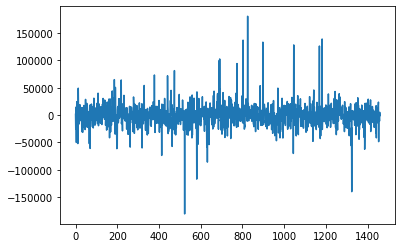

<IPython.core.display.Javascript object>

In [38]:
plt.plot(errors)
# they appear to be uncorrelated

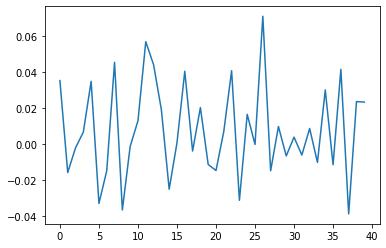

<IPython.core.display.Javascript object>

In [39]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()
# acf shows relatively low correlation in errors

In [40]:
errors_df = pd.concat([X, pd.DataFrame(errors)], axis=1)
sns.heatmap(errors_df.corr(), vmin=-1, vmax=1, annot=True)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000002151E507B88> (for post_execute):


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [49]:
abs(errors_df.corr()[0]).sort_values(ascending=False)
#doesn't seem to be a high correlation between errors and features

0              1.000000e+00
lotarea        2.354117e-12
Sev            1.328198e-12
Low            8.889382e-13
ClearCr        7.786451e-13
                   ...     
RRNe           1.580811e-15
RRAe           1.507268e-15
mosold         1.132612e-15
secondflrsf    4.628266e-16
ImStucc        2.830482e-16
Name: 0, Length: 231, dtype: float64

<IPython.core.display.Javascript object>